In [1]:
%load_ext autoreload 
%autoreload 2

import yaml
import json
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from fusanet_utils.datasets.simulated import SimulatedPoliphonic
from fusanet_utils.datasets.fusa import FUSA_dataset
from fusanet_utils.transforms import Collate_and_transform

scenarios = {0:'square', 1:'park', 2:'waterfront', 3:'market', 4:'street'}
is_scenario = lambda filename: [key for key, scene in scenarios.items() if scene in filename][0]

models_metadata = {0: {'name': 'Adavanne et al. 2017', 
                       'path': Path('../experiments/Poliphonic-ADAVANNE-sed/')},
                   1: {'name': 'Kong et al. 2019', 
                       'path': Path('../experiments/Poliphonic-PANN-sed-no-pretrained/')},
                   2: {'name': 'Chen et al. 2021 (loss)', 
                       'path': Path('../experiments/Poliphonic-HTS-valid-loss/')},
                   3: {'name': 'Chen et al. 2021', 
                       'path': Path('../experiments/Poliphonic-HTS/')}
                  }

    
preds_soft, labels, distances, places = {}, {}, {}, {}
for model_idx in [2, 3]:
    experiment_path = models_metadata[model_idx]['path']
    #categories = json.load(open(str(experiment_path / 'index_to_name.json')))
    model = torch.load(str(experiment_path / 'model.pt'))
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total parameters number: {pytorch_total_params}')
    print(f'Trainable parameters number: {pytorch_trainable_params}')
    model.eval()
    dataset = SimulatedPoliphonic('..', external=True, mini=False)
    params = yaml.safe_load(open(str(experiment_path / 'params.yaml')))
    fusa_dataset = FUSA_dataset(ConcatDataset([dataset]), feature_params=params["features"])
    fusa_loader = DataLoader(fusa_dataset, batch_size=10, shuffle=False, pin_memory=True, num_workers=2,
                             collate_fn=Collate_and_transform(params["features"]))
    preds_model, labels_model = [], []
    with torch.no_grad():
        for sample in tqdm(fusa_loader):
            preds_model.append(model(sample).numpy())
            labels_model.append(sample['label'].numpy())
    preds_soft[model_idx] = np.concatenate(preds_model)
    labels[model_idx] = np.concatenate(labels_model)
    distances[model_idx] = np.concatenate([sample[1]['distance'].values for sample in dataset])
    places[model_idx] = np.array([is_scenario(sample[0].stem) for sample in dataset])


Total parameters number: 28771163
Trainable parameters number: 27687707


  0%|          | 0/10 [00:00<?, ?it/s]

Total parameters number: 28771163
Trainable parameters number: 27687707


  0%|          | 0/10 [00:00<?, ?it/s]

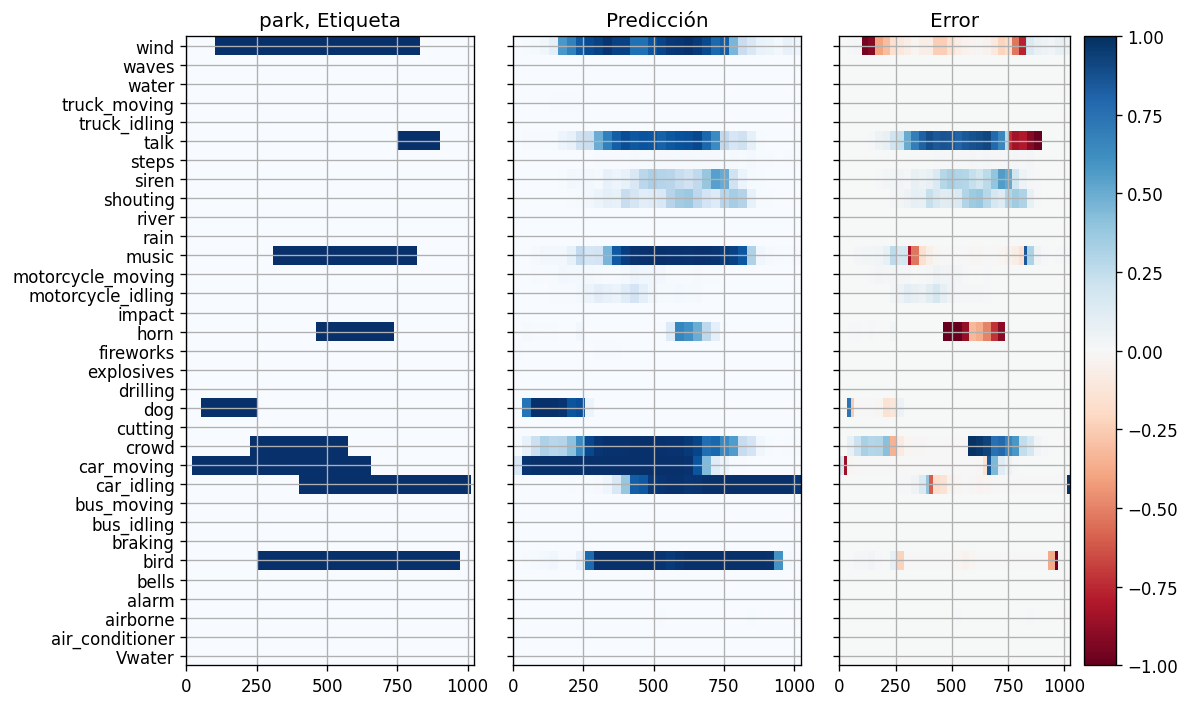

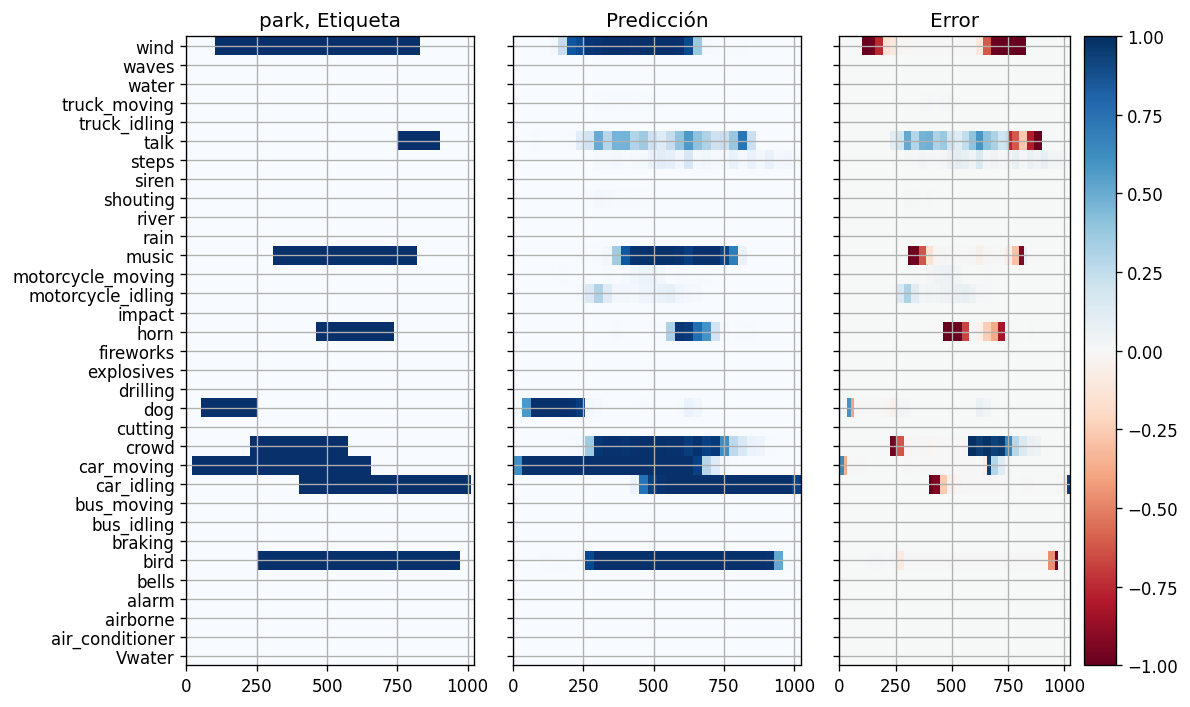

In [76]:
def plot_file_prediction(model_idx: int, sample_idx: int, th: float=None):
    if th is not None:
        pred = (preds_soft[model_idx][sample_idx] > th).T  
    else:
        pred = preds_soft[model_idx][sample_idx].T
    label = labels[model_idx][sample_idx].T
    
    fig, ax = plt.subplots(1, 3, figsize=(10, 6), facecolor='w', dpi=120,
                           tight_layout=True, sharex=True, sharey=True)
    ax[0].pcolormesh(label, cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax[0].set_title(f"{scenarios[places[model_idx][sample_idx]]}, Etiqueta")
    ax[1].pcolormesh(pred, cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax[1].set_title('Predicción')
    cmap = ax[2].pcolormesh((pred - label), cmap=plt.cm.RdBu, vmin=-1, vmax=1)
    fig.colorbar(cmap)
    ax[2].set_title('Error')
    ax[0].set_yticks(np.arange(0, len(dataset.categories), step=1) + 0.5)
    ax[0].set_yticklabels((dataset.categories));
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    
#plot_file_prediction(0, 90, 0.3)
#plot_file_prediction(1, 90, 0.3)
plot_file_prediction(2, 90)
plot_file_prediction(3, 90)

In [68]:
preds = {model: preds_soft[model] > 0.5 for model in preds_soft.keys()}

Por clase para todos los ambientes

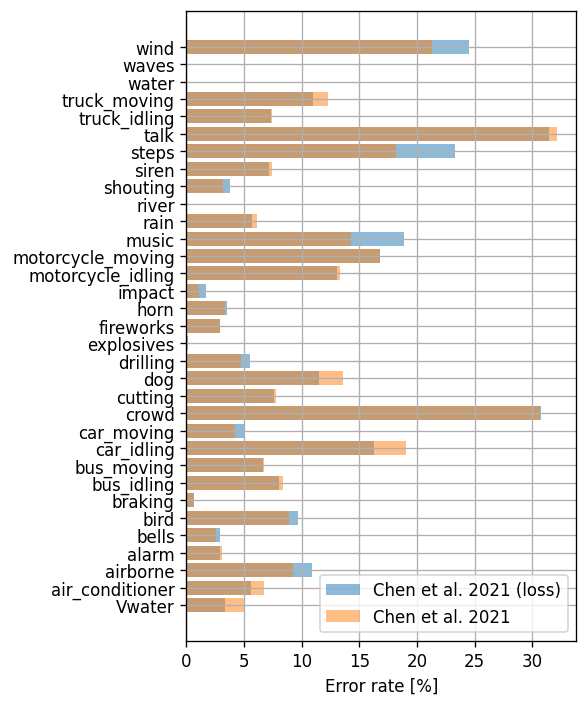

In [69]:
fig, ax = plt.subplots(figsize=(5, 6), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)

for idx in preds.keys():
    insertions = np.mean((preds[idx] == 1) & (labels[idx] == 0), axis=(0, 1))
    deletions = np.mean((preds[idx] == 0) & (labels[idx] == 1), axis=(0, 1))
    error_rate = insertions + deletions
    ax.barh(y=list(dataset.categories), width=100*error_rate, alpha=0.5, label=models_metadata[idx]['name'])

ax.legend()
ax.grid()
ax.set_xlabel('Error rate [%]');

Por ambiente separado por clase:

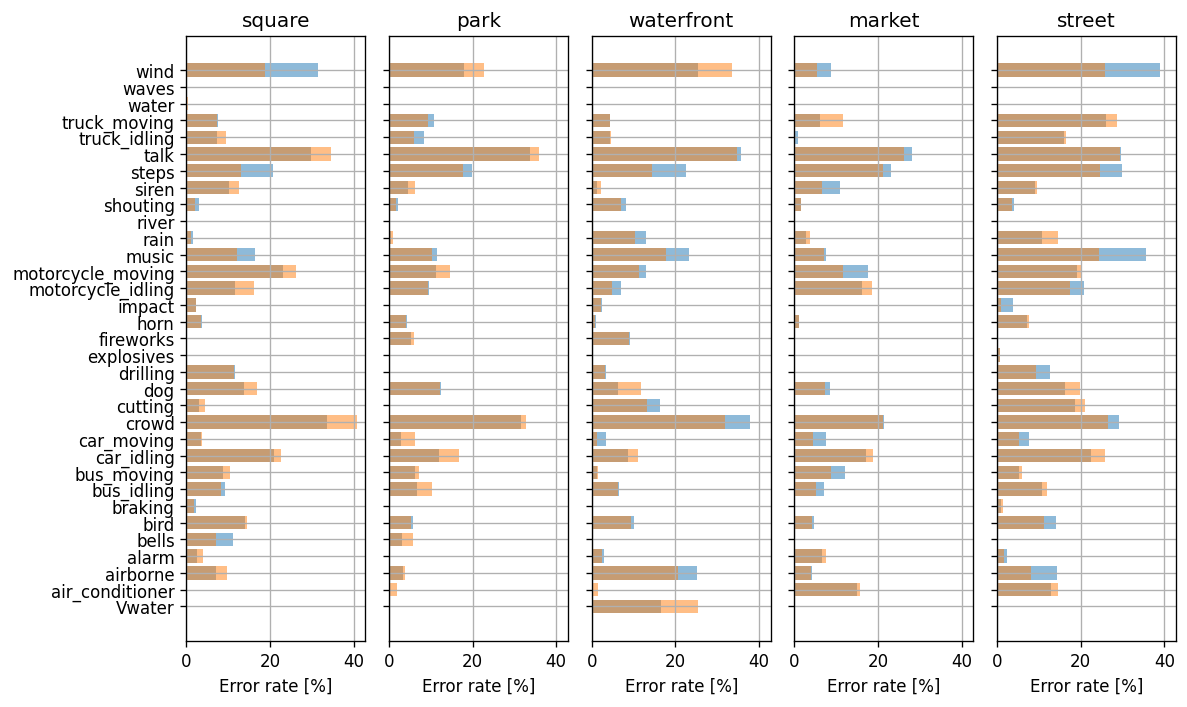

In [70]:
fig, ax = plt.subplots(1, 5, figsize=(10,  6), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)

for idx in preds.keys():
    insertions, deletions = [], []
    for place in scenarios.keys():
        mask = places[idx] == place
        insertions.append((preds[idx][mask] == 1) & (labels[idx][mask] == 0))
        deletions.append((preds[idx][mask] == 0) & (labels[idx][mask] == 1))        
    insertions = np.mean(np.stack(insertions), axis=(1, 2))
    deletions = np.mean(np.stack(deletions), axis=(1, 2))
    
    for ax_, ins, dels, scene in zip(ax, insertions, deletions, scenarios.values()):
        #print(ins)
        error_rate = (ins + dels)*100
        ax_.barh(y=list(dataset.categories), width=error_rate, 
                 label=models_metadata[idx]['name'], alpha=0.5)
        ax_.set_title(scene)
        ax_.grid('on')
        #ax_.legend()
        ax_.set_xlabel('Error rate [%]')

Por ambiente:

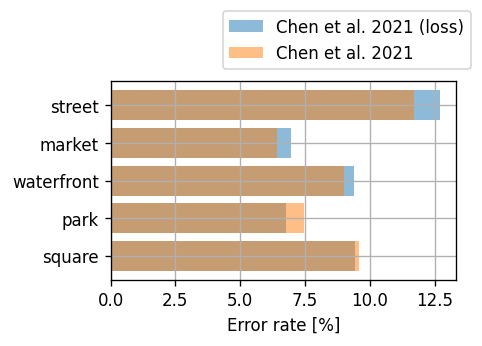

In [71]:
fig, ax = plt.subplots(figsize=(4, 3), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)

for idx in preds.keys():
    insertions, deletions = [], []
    for place in scenarios.keys():
        mask = places[idx] == place
        insertions.append((preds[idx][mask] == 1) & (labels[idx][mask] == 0))
        deletions.append((preds[idx][mask] == 0) & (labels[idx][mask] == 1))        
    insertions = np.mean(np.stack(insertions), axis=(1, 2, 3))
    deletions = np.mean(np.stack(deletions), axis=(1, 2, 3))
    error_rate = 100*(insertions+deletions)
    ax.barh(y=list(scenarios.values()), width=error_rate, 
            label=models_metadata[idx]['name'], alpha=0.5)

ax.legend(bbox_to_anchor=(0.3, 1.02, 1., .102))
ax.grid()
ax.set_xlabel('Error rate [%]');

Por macro clase:

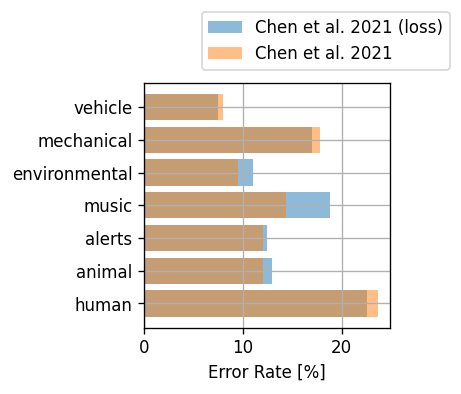

In [74]:
categories = {}
for k, category in enumerate(dataset.categories):
    categories[k] = category
inv_categories = {}
for key, values in categories.items():
    inv_categories[values] = int(key)
    
macro_classes = ['human', 'animal', 'alerts', 'music', 'environmental', 'mechanical', 'vehicle']
fusa_taxonomy = {0: ['crowd', 'shouting', 'talk', 'steps'],
                 1: ['bird', 'dog'], 
                 2: ['siren', 'bells', 'alarm', 'horn', 'braking'],
                 3: ['music'],
                 4: ['rain', 'wind', 'water', 'river', 'waves'],
                 5: ['cutting', 'drilling', 'fireworks', 
                     'impact', 'explosives', 'air_conditioner'],
                 6: ['car_idling', 'car_moving', 'bus_idling', 'bus_moving', 'airborne',
                     'motorcycle_idling', 'motorcycle_moving', 'truck_idling', 'truck_moving', 'Vwater']
                }
fusa_taxonomy_int = {}
for key, values in fusa_taxonomy.items():
    transformed_values = []
    for value in values:
        transformed_values.append(inv_categories[value])
    fusa_taxonomy_int[key] = transformed_values
        
inv_taxonomy = {}
for key, values in fusa_taxonomy_int.items():
    for value in values:
        inv_taxonomy[value] = key
        

fig, ax = plt.subplots(figsize=(4, 3), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)


for idx in preds.keys():    
    pred_macro = np.stack([np.amax(preds[idx][:, :, fusa_taxonomy_int[macro]], axis=-1) for macro in range(len(macro_classes))])
    label_macro = np.stack([np.amax(labels[idx][:, :, fusa_taxonomy_int[macro]], axis=-1) for macro in range(len(macro_classes))])

    insertions = np.mean((pred_macro == 1) & (label_macro==0), axis=(1, 2))
    deletions = np.mean((pred_macro == 0) & (label_macro==1), axis=(1, 2))

    error_rate = 100*(insertions + deletions)
    ax.barh(y=macro_classes, width=error_rate, label=models_metadata[idx]['name'], alpha=0.5)
ax.legend(bbox_to_anchor=(0.2, 1.02, 1., .102))
ax.grid()
ax.set_xlabel('Error Rate [%]');

Intercambio entre clase idling y clase moving: